In [478]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

DO = '#7D1B7E'
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


### Load and Read Data 

In [479]:
df = pd.read_csv('../data/top200-original.csv')

In [480]:
df.head(1) # look into DataFrame

,Position,Track Name,Artist,Streams,date,region,spotify_id
0,1.0,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,1867789.0,2019-01-01,us,3KkXRkHbMCARz0aVfEt68P


In [481]:
df.shape

(730000, 7)

In [482]:
df.isnull().sum() # Look for null values 

Position      200
Track Name    243
Artist        243
Streams       200
date            0
region          0
spotify_id    201
dtype: int64

In [483]:
df.dropna(axis = 0, inplace = True) # dropping null values 

In [484]:
df.dtypes

Position      float64
Track Name     object
Artist         object
Streams       float64
date           object
region         object
spotify_id     object
dtype: object

In [485]:
#converting position to a discrete value 
df['Position'] = df['Position'].apply(np.int64) 

In [486]:
# renaming region column values 
df['region'] = df['region'].replace('au', 'Australia')
df['region'] = df['region'].replace('br', 'Brazil')
df['region'] = df['region'].replace('ca', 'Canada')
df['region'] = df['region'].replace('us', 'USA')
df['region'] = df['region'].replace('de', 'Germany')
df['region'] = df['region'].replace('fr', 'France')
df['region'] = df['region'].replace('mx', 'Mexico')
df['region'] = df['region'].replace('nl', 'Netherlands')
df['region'] = df['region'].replace('se', 'Sweden')
df['region'] = df['region'].replace('gb', 'UK')

In [487]:
# Change date column to be datetime dtype
df.set_index(pd.to_datetime(df['date']), inplace = True)

In [488]:
df.drop(columns =['date'], inplace = True)

In [489]:
df.sort_index(inplace = True)

In [490]:
#creating dateframe for each region and then merging all on spotify_id 
df_USA = pd.DataFrame(df[df['region']=='USA'])
df_UK = pd.DataFrame(df[df['region']=='UK'])
df_Germany = pd.DataFrame(df[df['region']=='Germany'])
df_France = pd.DataFrame(df[df['region']=='France'])
df_Netherlands = pd.DataFrame(df[df['region']=='Netherlands'])
df_Sweden = pd.DataFrame(df[df['region']=='Sweden'])
df_Mexico = pd.DataFrame(df[df['region']=='Mexico'])
df_Canada = pd.DataFrame(df[df['region']=='Canada'])
df_Brazil = pd.DataFrame(df[df['region']=='Brazil'])
df_Australia = pd.DataFrame(df[df['region']=='Australia'])

In [491]:
from functools import reduce
df_regional= reduce(lambda x,y: pd.merge(x,y, on=['date', 'spotify_id']), 
                    [df_USA, df_UK, df_France, df_Canada, df_Sweden,df_Mexico, 
                     df_Australia, df_Brazil, df_Germany, df_Netherlands ])

## Modeling: Rank Prediction - Example: USA 

In [492]:
# Dummification of categorical variable 
df_USA_dummies = pd.get_dummies(data=df_USA , columns=['Artist'])

In [493]:
#Choosing matrix 
X= df_USA_dummies.drop(columns = ['Position', 'Track Name', 'spotify_id', 'region'])

In [494]:
# defining target
y = df_USA_dummies['Position']

In [495]:
# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42)

In [496]:
#Instantiate and fitting model
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Training Score: {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score: {round(lm.score(X_test, y_test),4)}.')

Training Score: 0.6073.
Testing Score: -126723334.7699.


In [497]:
#X_train_df = pd.DataFrame(X_train)

In [498]:
#X_train_df['preds'] = lm.predict(X_train)

In [499]:
#X_train_df.preds

In [500]:
#y_train

In [501]:
#Scaling data before running PCA
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [502]:
# Instantiate and fit PCA 
pca = PCA()
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [503]:
# Selecting most important components 
var_exp = pca.explained_variance_ratio_
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
#print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:500],3)}')

In [504]:
# fitting PCA with new components 
pca = PCA(n_components =455)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=455, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [505]:
#Instantiate model with PCA 
lm = LinearRegression()
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.6073
Testing Score: 0.6116


In [506]:
#svc = SVC(gamma = 'scale')
#Z_train = pca.transform(X_train)
#Z_test = pca.transform(X_test)
#svc.fit(Z_train, y_train)
#y_pred_svc_tr = svc.predict(Z_train)
#y_pred_svc = svc.predict(Z_test)
##print(f'Training Score: {round(svc.score(Z_train, y_train),4)}')
#print(f'Testing Score: {round(svc.score(Z_test, y_test),4)}')
#
#
#y_predict = lm.predict(X_test)
#print(y_predict)

# Modeling with new columns  with scaling & PCA
## Pilot: USA 

In [555]:
# creating new columns/dataframe to be used as matrix for our models
new_cols_rank = df_USA.groupby(['date','Artist', 'region']).agg({'Position': ['mean', 'min', 'max']})
new_cols_rank.columns = ['avg_rank', 'top_rank', 'low_rank']

In [556]:
# creating new columns/dataframe to be used as matrix for our models for ranks 
new_cols_streams = df_USA.groupby(['date', 'Artist','region']).agg({'Streams': ['mean', 'max', 'min']})
new_cols_streams.columns = ['avg_streams', 'max_streams', 'min_streams']

In [557]:
# merging two DF for consolidated data
df_USA_all= pd.merge(new_cols_rank, new_cols_streams, on =['date', 'region', 'Artist'])
df_USA_all.head(2)

avg_rank  top_rank  low_rank  \
date       region Artist                                              
2019-01-01 USA    21 Savage             107.125        14       184   
                  5 Seconds of Summer    67.000        67        67   

                                       avg_streams  max_streams  min_streams  
date       region Artist                                                      
2019-01-01 USA    21 Savage              363158.25     708965.0     204009.0  
                  5 Seconds of Summer    355206.00     355206.0     355206.0

In [558]:
#resetting index
df_USA_all.reset_index(level=['region', 'Artist'], inplace = True)

In [560]:
# dummification of categorical variable
df_USA_all_dummies = pd.get_dummies(data=df_USA_all , columns=['Artist'])

In [561]:
X_new = df_USA_all_dummies.drop(columns = ['region', 
                                           'avg_rank', 'top_rank', 'low_rank', 
                                           ])

In [591]:
# Choosing target
y_new = df_USA_all_dummies[['low_rank', 'top_rank', 'avg_rank']]

In [563]:
# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new,
                                                   random_state = 42)

In [565]:
# Tunning model & fit it 
lm = MultiOutputRegressor(LinearRegression())
lm.fit(X_train, y_train)
print(f'Training Score: {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score: {round(lm.score(X_test, y_test),4)}.')

Training Score: 0.7216.
Testing Score: -36595151.4393.


In [566]:
# Scaling data for PCA 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [567]:
# Instantiate PCA and fitting
pca = PCA()
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [576]:
# Selecting components 
var_exp = pca.explained_variance_ratio_
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
#print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:440],3)}')

In [574]:
#instantiate with important components 
pca = PCA(n_components =452)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=452, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [575]:
# Tune & fit model 
lm = MultiOutputRegressor(LinearRegression())
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.7216
Testing Score: 0.7163


In [593]:
# Look into predictions 
y_pred_train= lm.predict(Z_train)
y_pred_test = lm.predict(Z_test)

In [617]:
preds = pd.DataFrame(y_pred_test)
preds.columns=['avg_rank_pred', 'top_rank_pred', 'low_rank_pred']

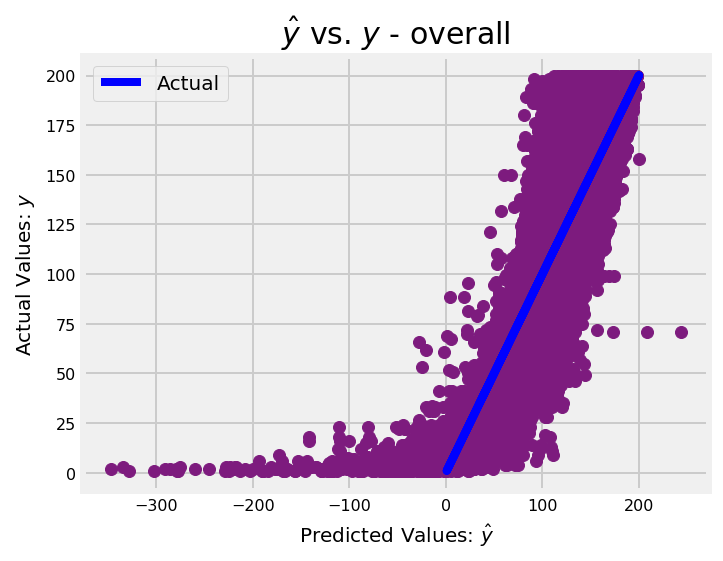

In [618]:
# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (5,4))
plt.scatter(y_pred_test,y_test, c = DO);
plt.plot( y_test,y_test, c = 'blue');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - overall", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);


In [619]:
# selecting relevant column for seperate assessment
y_test_avg = y_test['avg_rank']
y_test_top = y_test['top_rank']
y_test_low = y_test['low_rank']

In [620]:
# creating Dataframe for preds
preds = pd.DataFrame(y_pred_test)
preds.columns=['avg_rank', 'top_rank', 'low_rank']
y_preds_test_avg = preds['avg_rank']
y_preds_test_top = preds['top_rank']
y_preds_test_low = preds['low_rank']


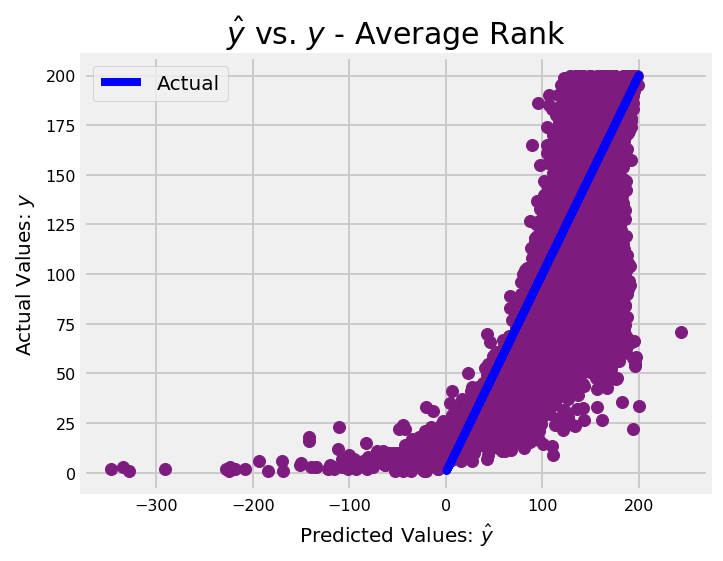

In [621]:
# Plotting to compare actual vs preds for avg rank 
plt.figure(figsize = (5,4))
plt.scatter(y_preds_test_avg,y_test_avg, c = DO);
plt.plot( y_test,y_test, c = 'blue');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Average Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);


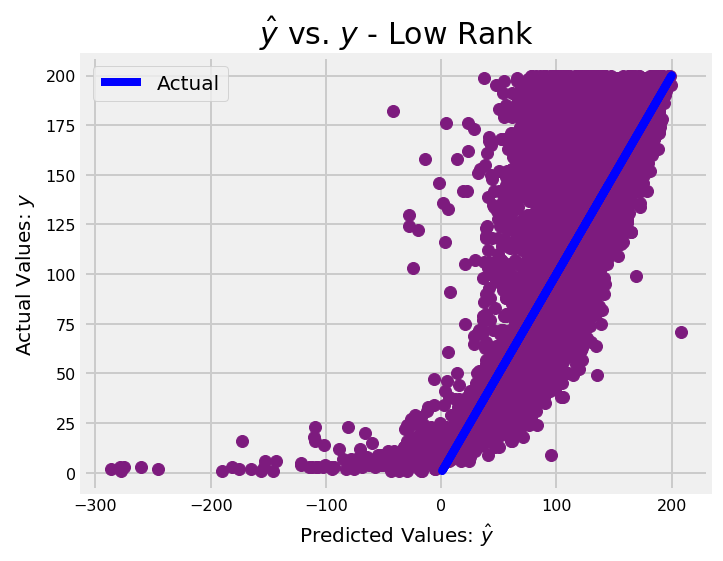

In [622]:
# Plotting to compare actual vs preds for low rank 
plt.figure(figsize = (5,4))
plt.scatter(y_preds_test_low,y_test_low, c = DO);
plt.plot( y_test,y_test, c = 'blue');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Low Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);


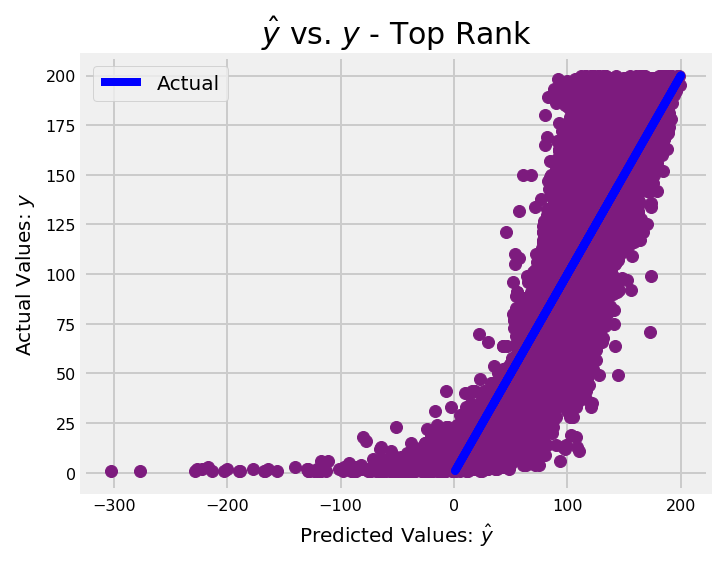

In [623]:
# Plotting to compare actual vs preds for top rank 
plt.figure(figsize = (5,4))
plt.scatter(y_preds_test_top,y_test_top, c = DO);
plt.plot( y_test,y_test, c = 'blue');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("$\hat{y}$ vs. $y$ - Top Rank", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);


In [626]:
print('RMSE - Overall:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('RMSE - Average Rank:', np.sqrt(metrics.mean_squared_error(y_test_avg, y_preds_test_avg)))
print('RMSE - Top Rank:',np.sqrt(metrics.mean_squared_error(y_test_top, y_preds_test_top)))
print('RMSE - ALow Rank:',np.sqrt(metrics.mean_squared_error(y_test_low, y_preds_test_low)))

RMSE - Overall: 28.957244034489907
RMSE - Average Rank: 40.686309548774446
RMSE - Top Rank: 30.87378293863417
RMSE - ALow Rank: 42.00155888949794
